In [1]:
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import Normalize, ListedColormap
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from cutshapefile import transform_from_latlon, rasterize
import geopandas as gpd
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'axes.grid': False,
    'savefig.dpi': 700,
    'font.size': 12,
    'text.usetex': True,
    'figure.figsize': [5, 5],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

In [2]:
with xr.open_dataset('/nfs/a68/earlacoa/population/count/v4.11/2020/gpw_v4_population_count_rev11_2020_0.25deg_crop.nc') as ds:
    pop = ds['pop']
    
with xr.open_dataset('/nfs/a68/earlacoa/shared/wrfout_2015_PM2_5_DRY_annual_mean_0.25deg.nc') as ds:
    pm25 = ds['PM2_5_DRY']
    
xx, yy = np.meshgrid(pop.lon.values, pop.lat.values)

In [3]:
def plot(variable, label, region='global'):
    fig = plt.figure(1, figsize=(10, 10))
    gs = gridspec.GridSpec(1, 1)
    ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
    if region == 'global':
        ax.set_extent([-180, 180, -60, 85], crs=ccrs.PlateCarree())
        ax.coastlines()
    elif region == 'china':
        ax.set_extent([73, 135, 18, 54], crs=ccrs.PlateCarree())
        shape_feature = ShapelyFeature(
            Reader('/nfs/a68/earlacoa/shapefiles/china/CHN_adm0.shp').geometries(),                             
            ccrs.PlateCarree(), 
            facecolor='none'
        )
        ax.patch.set_visible(False)
        ax.spines['geo'].set_visible(False)
        ax.add_feature(shape_feature, edgecolor='black', linewidth=1)
    norm = Normalize(vmin=0, vmax=variable.max())
    cmap = 'viridis'
    im = ax.contourf(
        xx, yy, 
        variable.values, 
        np.arange(0, variable.max().values, 11), 
        cmap=cmap, norm=norm, 
        transform=ccrs.PlateCarree()
    )
    sm = plt.cm.ScalarMappable(norm=norm, cmap=im.cmap)
    sm.set_array([])  
    cb = plt.colorbar(sm, norm=norm, cmap=cmap, ticks=[int(num) for num in np.arange(0, variable.max().values, 11)], shrink=0.47)
    cb.set_label(label, size=14)
    cb.ax.tick_params(labelsize=14)
    fig.canvas.draw()
    gs.tight_layout(fig, rect=[0, 0, 0.95, 0.95], h_pad=1, w_pad=1) 
    plt.show()

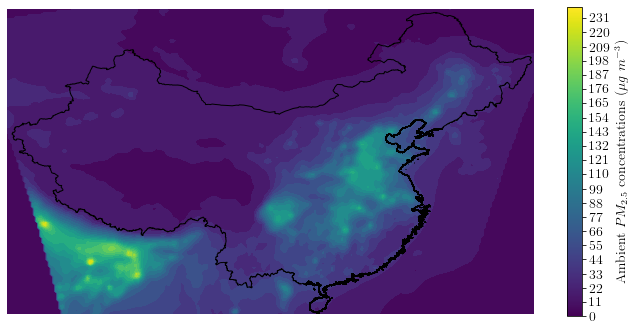

In [4]:
plot(pm25, 'Ambient $PM_{2.5}$ concentrations (${\mu}g$ $m^{-3}$)', region='china')

In [5]:
def crop_ds_to_shapefile(ds, shapefile):
    # load shapefile (single multipolygon) and extract shapes
    shapefile = gpd.read_file(shapefile)
    shapes = [(shape, index) for index, shape in enumerate(shapefile.geometry)]
    
    # apply shapefile to geometry, default: inside shapefile == 0, outside shapefile == np.nan
    ds['shapefile'] = rasterize(shapes, ds.coords, longitude='lon', latitude='lat') 

    # change to more intuitive labelling of 1 for inside shapefile and np.nan for outside shapefile
    # if condition preserve (outside shapefile, as inside defaults to 0), otherwise (1, to mark in shapefile)
    ds['shapefile'] = ds.shapefile.where(cond=ds.shapefile!=0, other=1) 

    # example: crop data to shapefile
    # if condition (not in shapefile) preserve, otherwise (in shapefile, and scale)
    ds = ds.where(cond=ds.shapefile==1, other=np.nan) 
    
    return ds

In [6]:
pm25_china = crop_ds_to_shapefile(pm25, '/nfs/a68/earlacoa/shapefiles/china/CHN_adm0.shp')

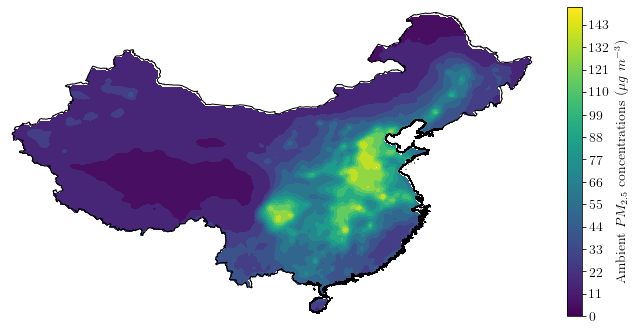

In [7]:
plot(pm25_china, 'Ambient $PM_{2.5}$ concentrations (${\mu}g$ $m^{-3}$)', region='china')

In [8]:
pop_china = crop_ds_to_shapefile(pop, '/nfs/a68/earlacoa/shapefiles/china/CHN_adm0.shp')

In [9]:
pop_china.sum()

<xarray.DataArray 'pop' ()>
array(1.38790373e+09)

In [10]:
# population weighted exposure over an area
pm25_china_popweighted = ((pm25_china * pop_china) / pop_china.sum()).sum().values

In [11]:
pm25_china_popweighted

array(73.62529163)